## Quality Check Diagnostic Work, Part B

This notebook illustrates some quality control steps that should be considered when analyzing a new dataset. In this example we'll use the `WindToolKitQualityControlDiagnosticSuite` class to automate some of the QC analysis for SCADA data.

The `WindToolKitQualityDiagnosticSuite` is a subclass of the `QualityControlDiagnosticSuite` that adds additional methods for the use of the NREL WindToolKit database in addition to all the base QC methods.

In Part B of this exercise, we will demonstrate the use of timezone-aware timestamps.

### Step 1: Load in Data

To load in the data, we can either preload the data, or pass in a full file path and have the QC class import the data file. We'll import the data first to give a glimpse into what the data look like.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from operational_analysis.methods.quality_check_automation import WindToolKitQualityControlDiagnosticSuite as QC

In [3]:
scada_df = pd.read_csv('./data/la_haute_borne/la-haute-borne-data-2014-2015.csv')

In [4]:
scada_df.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001


### Step 2: Initializing QC and Performing the Run Method

Now that we have our dataset with the necessary columns and datatypes, we are ready to perform our quality check diagnostic. This analysis will not make the adjustments for us, but it will allow us to quickly flag some key irregularities that we need to manage before going on. 

To start, let's initialize a QC object, qc, and call its run method. 

In [5]:
qc = QC(
    data=scada_df, 
    ws_field='Ws_avg', 
    power_field= 'P_avg', 
    time_field='Date_time', 
    id_field='Wind_turbine_name', 
    freq='10T', 
    lat_lon=(48.45, 5.586),
    local_tz="Europe/Paris",  # While it may already be present in the timestamps, this should be used!
    timezone_aware=True,  # We should indicate that the timezone in the data is known
    check_tz=False,  # True for WIND ToolKit-valid locations only, though will not break the code if outside
)

INFO:operational_analysis.methods.quality_check_automation:Initializing QC_Automation Object


Below is what the updated DataFrame object looks like after being read in and manipulated for the initial setup. Notice that there is now a UTC offset column, which directly translates to the `is_dst` column's `True`/`False` input for whether or not a particular timestamp is in Daylight Saving's Time (if it's used at all for the time zone).

In the below, the Date_time_UTC column should always remain in UTC time and the Date_time_localized column should always remain in the localized time. Conveniently, Pandas provides two methods `tz_convert()` and `tz_localize()` to toggle back and forth between timezones, which will operate on the index of the DataFrame. It is worth noting that the local time could also be UTC, in which case the two columns would be redundant.

The localized time, even when the passed data is unaware, is adjusted using the `local_tz` keyword argument to help normalize the time strings, from which a UTC-based timestamp is created (even when local is also UTC). By calculating the UTC time from the local time, we are able to ascertain DST shifts in the data, and better assess any anomalies that may exist.

In [6]:
qc._df.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg,Date_time_localized,Date_time_utc,utc_offset,is_dst
Date_time_utc,,,,,,,,,,,,,
2014-01-01 00:00:00+00:00,R80736,2014-01-01 01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80721,2014-01-01 01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80790,2014-01-01 01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:00:00+00:00,R80711,2014-01-01 01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000,2014-01-01 01:00:00+01:00,2014-01-01 00:00:00+00:00,0 days 01:00:00,False
2014-01-01 00:10:00+00:00,R80790,2014-01-01 01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001,2014-01-01 01:10:00+01:00,2014-01-01 00:10:00+00:00,0 days 01:00:00,False


In [7]:
qc._df.dtypes

Wind_turbine_name                            object
Date_time              datetime64[ns, Europe/Paris]
Ba_avg                                      float64
P_avg                                       float64
Ws_avg                                      float64
Va_avg                                      float64
Ot_avg                                      float64
Ya_avg                                      float64
Wa_avg                                      float64
Date_time_localized    datetime64[ns, Europe/Paris]
Date_time_utc                   datetime64[ns, UTC]
utc_offset                          timedelta64[ns]
is_dst                                         bool
dtype: object

In [8]:
qc.run()

INFO:operational_analysis.methods.quality_check_automation:Identifying Time Duplications
INFO:operational_analysis.methods.quality_check_automation:Identifying Time Gaps
INFO:operational_analysis.methods.quality_check_automation:Isolating Extrema Values
INFO:operational_analysis.methods.quality_check_automation:QC Diagnostic Complete


### Step 3: Deep Dive with QC Diagnostic Results

Let's take a deeper look at the results of our QC diagnostic. 

#### Perform a general scan of the distributions for each numeric variable

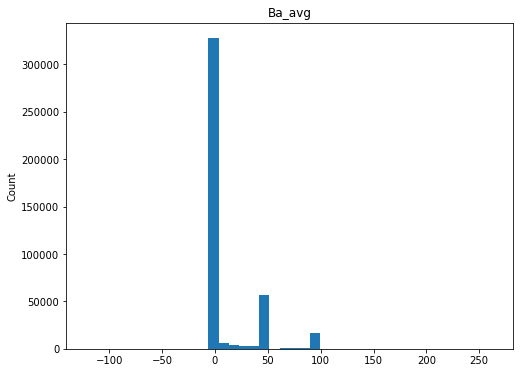

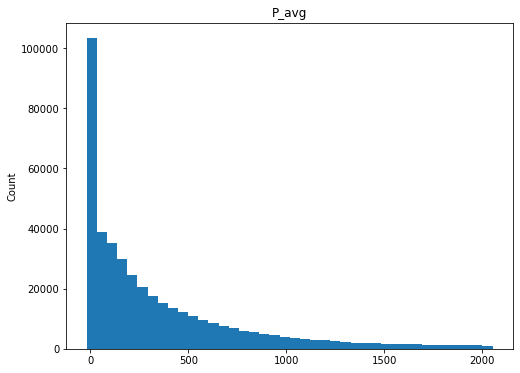

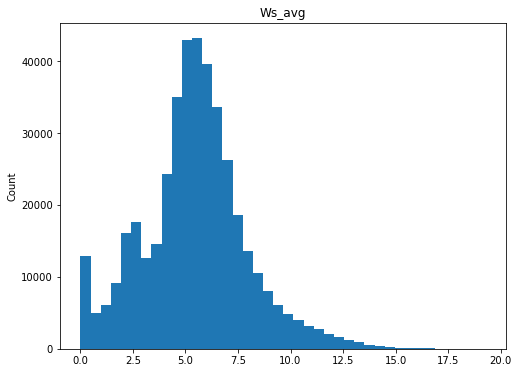

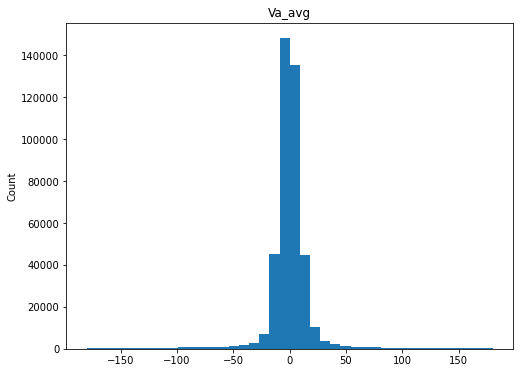

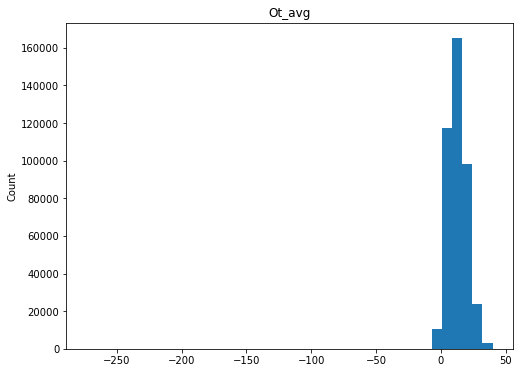

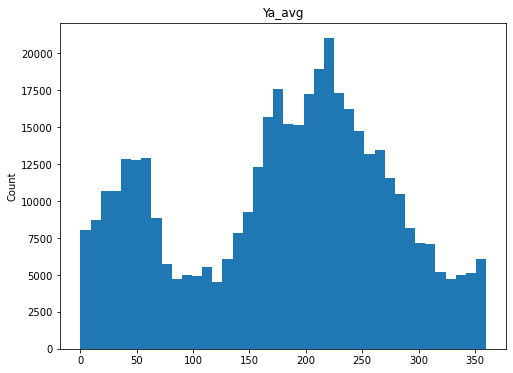

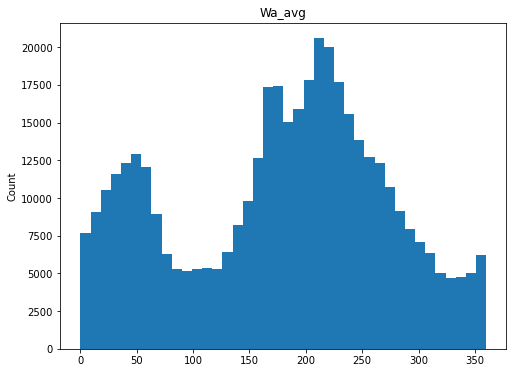

In [9]:
qc.column_histograms()

#### Check ranges of each variable

In [10]:
qc._max_min

,min,max
Wind_turbine_name,R80711,R80790
Date_time,2014-01-01 01:00:00+01:00,2016-01-01 00:50:00+01:00
Ba_avg,-121.26,262.61
P_avg,-17.92,2051.87
Ws_avg,0,19.31
Va_avg,-179.95,179.99
Ot_avg,-273.2,39.89
Ya_avg,0,360
Wa_avg,0,360
Date_time_localized,2014-01-01 01:00:00+01:00,2016-01-01 00:50:00+01:00


These values look fairly reasonable and consistent. 

#### Identify any timestamp duplications and timestamp gaps. 

Duplications in October and gaps in March would suggest DST.

In [11]:
qc._time_duplications 

Date_time_utc
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:00:00+00:00   2014-03-30 03:00:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:10:00+00:00   2014-03-30 03:10:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:20:00+00:00   2014-03-30 03:20:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:30:00+00:00   2014-03-30 03:30:00+02:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00+02:00
2014-03-30 01:40:00+00:00   2014-03-30 03:40:00+02:00
2014-03-30 01:

In [12]:
qc._time_gaps

42912   2014-10-26 02:00:00+02:00
42913   2014-10-26 02:10:00+02:00
42914   2014-10-26 02:20:00+02:00
42915   2014-10-26 02:30:00+02:00
42916   2014-10-26 02:40:00+02:00
42917   2014-10-26 02:50:00+02:00
95328   2015-10-25 02:00:00+02:00
95329   2015-10-25 02:10:00+02:00
95330   2015-10-25 02:20:00+02:00
95331   2015-10-25 02:30:00+02:00
95332   2015-10-25 02:40:00+02:00
95333   2015-10-25 02:50:00+02:00
dtype: datetime64[ns, Europe/Paris]

Based on the duplicated timestamps, it does seem like there is a DST correction in spring and a time gap in the fall

#### Check the DST plot to look in more detail

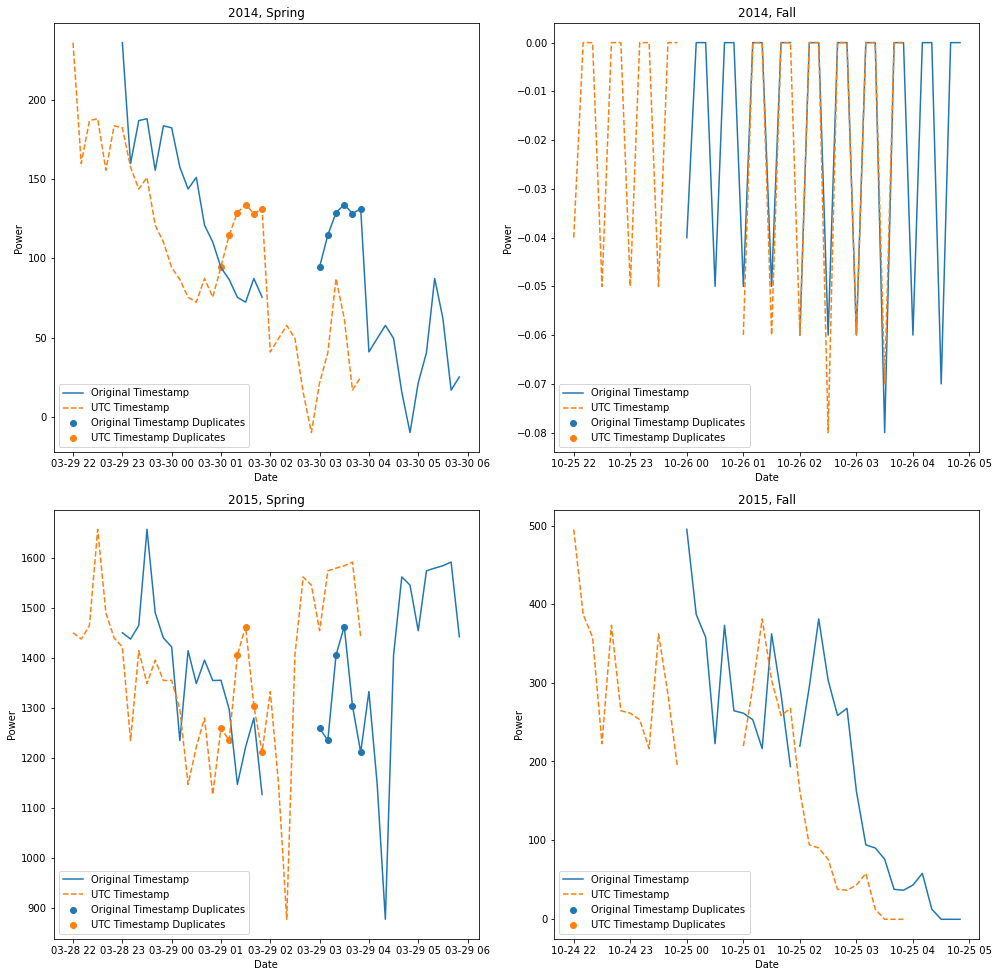

In [13]:
qc.daylight_savings_plot()

It should be noted that we are able to observe the same phenomena in Part A of this tutorial, which is expected given that it is the same data, but here we already have the timezone encoded within the timestamps, and so are able to confirm that the gaps present in the data are due to the DST transition, and the duplications are only partially due to the transition without having to question the timezone information.

### Inspect the turbine power curves

Now that we have gathered some useful information about our timeseries, the one last check we may want to make is to inspect each turbine profile. We can look at each turbine's power curve and perform an initial scan for irregularities.

/Users/rhammond/Documents/GitHub/OpenOA/operational_analysis/methods/quality_check_automation.py:488: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, 4, n)


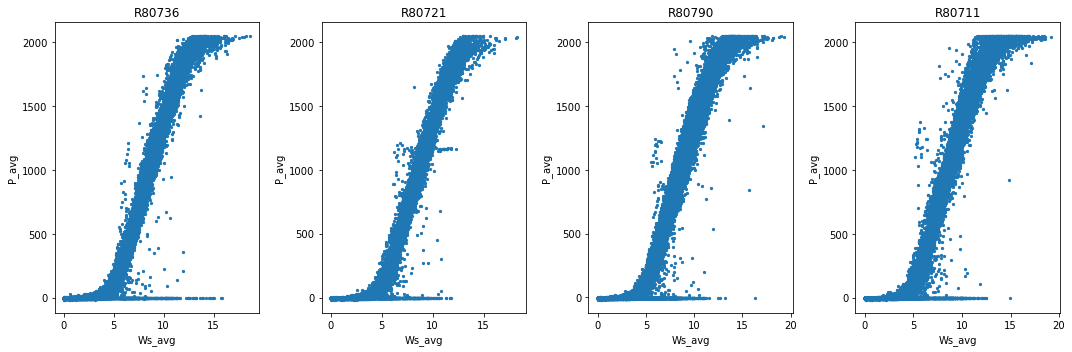

In [14]:
qc.plot_by_id('Ws_avg', 'P_avg')

Overall, these power curves look pretty common with some downtime, derating, and what look like a few erroneous data points. 

### Step 4: Performing adjustments on our data

Recall that this notebook is only for diagnostic QC of plant data and does not actually change the data in the project import script. Any issues identifed here should be incorporated into the project import script. 

Note that the necessary corrections have already been applied to the project import script for this data.